In [88]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

Useful funtions

In [89]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df, 
                        x='comp1', 
                        y='comp2', 
                        z='comp3',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df, 
                        x='comp1', 
                        y='comp2', 
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


Get Data

In [90]:
df = pd.read_csv("../../cleaned_data_v2.csv")
df.drop(columns = ["bathroom_category"], inplace = True)


In [91]:
df_embedding = pd.read_csv("embedding_train.csv")

Outliers

In [92]:
from pyod.models.ecod import ECOD
# https://github.com/yzhao062/pyod

clf = ECOD()
clf.fit(df_embedding)


out = clf.predict(df_embedding) 
df_embedding["outliers"] = out
df["outliers"] = out

df_embedding_no_out = df_embedding[df_embedding["outliers"] == 0]
df_embedding_no_out = df_embedding_no_out.drop(["outliers"], axis = 1)


df_embedding_with_out = df_embedding.copy()
df_embedding_with_out = df_embedding_with_out.drop(["outliers"], axis = 1)

In [93]:
df_embedding_no_out.shape

(19451, 384)

In [94]:
df_embedding_with_out.shape

(21613, 384)

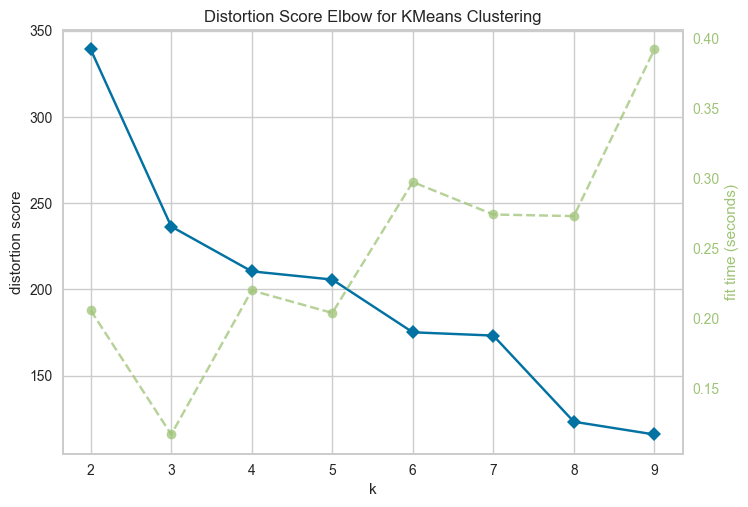

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [95]:
# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), locate_elbow=False)
 
visualizer.fit(df_embedding_with_out)        # Fit the data to the visualizer
visualizer.show()       

Best Number of Clusters

In [96]:
def make_Silhouette_plot(X, n_clusters):
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )
# Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
        plt.xlabel("The silhouette coefficient values", fontsize=24)
        plt.ylabel("Cluster label", fontsize=24)
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.yticks([])  
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
range_n_clusters = list(range(2,10))
for n_clusters in range_n_clusters:
    print(f"N cluster: {n_clusters}")
    make_Silhouette_plot(df_embedding_no_out, n_clusters)   
    plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
    plt.close()

N cluster: 2
For n_clusters = 2 The average silhouette_score is : 0.512723038456564
N cluster: 3
For n_clusters = 3 The average silhouette_score is : 0.5282896355866123
N cluster: 4
For n_clusters = 4 The average silhouette_score is : 0.4467649975789438
N cluster: 5
For n_clusters = 5 The average silhouette_score is : 0.4546404740916589
N cluster: 6
For n_clusters = 6 The average silhouette_score is : 0.33830308260710146
N cluster: 7
For n_clusters = 7 The average silhouette_score is : 0.3497381927524094
N cluster: 8
For n_clusters = 8 The average silhouette_score is : 0.36857249632900924
N cluster: 9
For n_clusters = 9 The average silhouette_score is : 0.377061118531989


![Alt text](kpropotype_no_out.png)

The best number is 5-6

Modeling

In [97]:
n_clusters = 3

In [98]:
clusters = KMeans(n_clusters=n_clusters, init = "k-means++").fit(df_embedding_no_out)
print(clusters.inertia_)
clusters_predict = clusters.predict(df_embedding_no_out)
df_no_outliers['cluster'] = clusters_predict

179.1688583754365


Evaluation

In [99]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(df_embedding_no_out,clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(df_embedding_no_out,clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(df_embedding_no_out,clusters_predict)}")

Davies bouldin score: 0.736367167931966
Calinski Score: 11084.550209040468
Silhouette Score: 0.5282896355866123


In [100]:
pca_3d_object, df_pca_3d = get_pca_3d(df_embedding_no_out, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0            125.696        32.73%                     32.73%
1             63.784        16.61%                     49.34%
2             49.814        12.97%                     62.32%


![Alt text](img/embedding1.png)

In [101]:
pca_2d_object, df_pca_2d = get_pca_2d(df_embedding_no_out, clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.2)


![Alt text](img/embedding2.png)

t-SNE   3D

In [102]:
sampling_data = df_embedding_no_out.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
                  n_components=3, 
                  learning_rate=500, 
                  init='random', 
                  perplexity=200, 
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=1, width_line = 0.1)

![Alt text](img/embedding3.png)

In [103]:
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=0.1, width_line = 0.1)

t-SNE 2D

In [65]:
# df_tsne_2d = TSNE(
#                   n_components=2, 
#                   learning_rate=500, 
#                   init='random', 
#                   perplexity=200, 
#                   n_iter = 5000).fit_transform(sampling_data)

# df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
# df_tsne_2d["cluster"] = sampling_clusters

# plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=0.5, width_line = 0.5)


![Alt text](img/embedding4.png)

In [66]:
# plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)


<h1> Explanations </h1>

In [104]:
df_no_outliers = df[df["outliers"] == 0]
df_no_outliers = df_no_outliers.drop("outliers", axis = 1)

In [105]:
df_no_outliers

price  bedrooms  bathrooms  sqft_lot  floors  waterfront  view  \
0       221900.0         3       1.00      5650     1.0           0     0   
1       538000.0         3       2.25      7242     2.0           0     0   
2       180000.0         2       1.00     10000     1.0           0     0   
3       604000.0         4       3.00      5000     1.0           0     0   
4       510000.0         3       2.00      8080     1.0           0     0   
...          ...       ...        ...       ...     ...         ...   ...   
21606  1007500.0         4       3.50      7200     2.0           0     0   
21607   475000.0         3       2.50      1294     2.0           0     0   
21608   360000.0         3       2.50      1131     3.0           0     0   
21609   400000.0         4       2.50      5813     2.0           0     0   
21611   400000.0         3       2.50      2388     2.0           0     0   

       condition  yr_built  yr_renovated  zipcode      lat     long  \
0              3      1955             0    98178  47.5112 -122.257   
1              3      1951          1991    98125  47.7210 -122.319   
2              3      1933             0    98028  47.7379 -122.233   
3              5      1965             0    98136  47.5208 -122.393   
4              3      1987             0    98074  47.6168 -122.045   
...          ...       ...           ...      ...      ...      ...   
21606          3      2009             0    98136  47.5537 -122.398   
21607          3      2008             0    98116  47.5773 -122.409   
21608          3      2009             0    98103  47.6993 -122.346   
21609          3      2014             0    98146  47.5107 -122.362   
21611          3      2004             0    98027  47.5345 -122.069   

       nearest_station_distance_km  density  commute_time  \
0                      8620.002287   5364.0          32.9   
1                      2078.181042   7999.0          28.9   
2                      8109.552186   3833.0          33.1   
3                      8918.318639   7517.0          30.6   
4                     19789.800401   2896.0          32.7   
...                            ...      ...           ...   
21606                  6800.016165   7517.0          30.6   
21607                  6359.084316   9060.0          32.7   
21608                  1372.516972  11391.0          27.1   
21609                  8505.181320   6034.0          29.8   
21611                 18943.445917    487.0          29.3   

       distance_to_point_km  is_near_shore  grade_living  
0                  0.595763          False          8260  
1                  3.038596          False         17990  
2                  2.317669          False          4620  
3                  0.101668           True         13720  
4                  1.750656          False         13440  
...                     ...            ...           ...  
21606              0.105088           True         31590  
21607              0.274047           True         10480  
21608              1.708484          False         12240  
21609              1.990125          False         18480  
21611              2.354171          False         12800  

[19451 rows x 19 columns]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7857
[LightGBM] [Info] Number of data points in the train set: 19451, number of used features: 20
[LightGBM] [Info] Start training from score -0.224095
[LightGBM] [Info] Start training from score -1.957389
[LightGBM] [Info] Start training from score -2.821204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

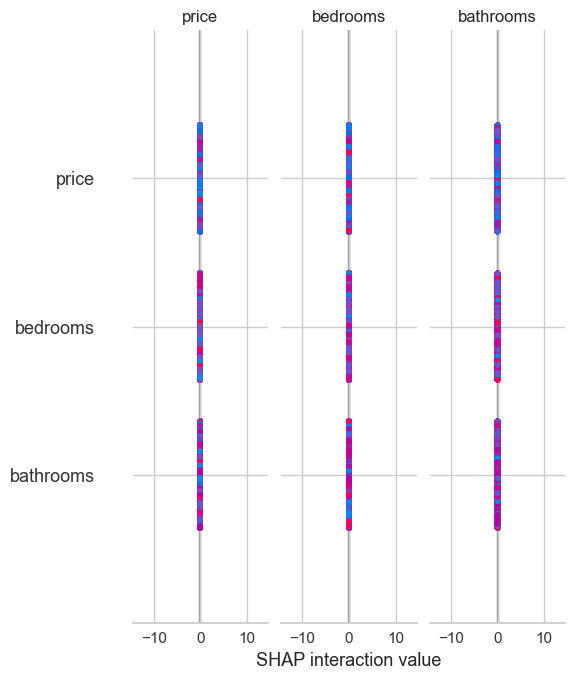

In [128]:
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)

categorical_columns = ['zipcode']

# Convert specified columns to 'category' dtype
for col in categorical_columns:
    df_no_outliers[col] = df_no_outliers[col].astype('category')

clf_km.fit(X = df_no_outliers , y = clusters_predict)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(df_no_outliers)
shap.summary_plot(shap_values_km, df_no_outliers, plot_type="bar", plot_size=(15, 10))

In [107]:
y_pred = clf_km.predict(df_no_outliers)
accuracy=accuracy_score(y_pred, clusters_predict)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy))
print(classification_report(clusters_predict, y_pred))

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
Training-set accuracy score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15546
           1       1.00      1.00      1.00      2747
           2       1.00      1.00      1.00      1158

    accuracy                           1.00     19451
   macro avg       1.00      1.00      1.00     19451
weighted avg       1.00      1.00      1.00     19451



Cluster Info

In [108]:
df_no_outliers["cluster"] = clusters_predict


In [133]:
df_no_outliers["cluster_2"]  = clusters

In [110]:
# clusters on lat long scatter plot
fig = px.scatter_mapbox(df_no_outliers, 
                        lat="lat", 
                        lon="long", 
                        color="cluster",
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        zoom=10,
                        mapbox_style="carto-positron",
                        title="Clusters on Lat Long",
                        height=800,
                        width=1000)

fig.show()



In [139]:
df_no_outliers["cluster"].value_counts()

cluster
KMeans(n_clusters=3)    19451
Name: count, dtype: int64

In [132]:
df_no_outliers["cluster"]

0        KMeans(n_clusters=3)
1        KMeans(n_clusters=3)
2        KMeans(n_clusters=3)
3        KMeans(n_clusters=3)
4        KMeans(n_clusters=3)
                 ...         
21606    KMeans(n_clusters=3)
21607    KMeans(n_clusters=3)
21608    KMeans(n_clusters=3)
21609    KMeans(n_clusters=3)
21611    KMeans(n_clusters=3)
Name: cluster, Length: 19451, dtype: object

In [114]:
df_no_outliers.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront',
       'view', 'condition', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'nearest_station_distance_km', 'density', 'commute_time',
       'distance_to_point_km', 'is_near_shore', 'grade_living', 'cluster'],
      dtype='object')

In [115]:
df_no_outliers["cluster"] = clusters_predict

df_group = df_no_outliers.groupby('cluster').agg(
    {
        'price': 'mean',
        'bedrooms': lambda x: x.value_counts().index[0],
        'bathrooms': lambda x: x.value_counts().index[0],
        'sqft_lot': 'mean',
        'floors': lambda x: x.value_counts().index[0],
        'waterfront': lambda x: x.value_counts().index[0],
        'view': lambda x: x.value_counts().index[0],
        'condition': lambda x: x.value_counts().index[0],
        'yr_built': 'mean',
        'yr_renovated': 'mean',
        'zipcode': lambda x: x.value_counts().index[0],
        'lat': 'mean',
        'long': 'mean',
        'nearest_station_distance_km': 'mean',
        'density': 'mean',
        'commute_time': 'mean',
        'distance_to_point_km': 'mean',
        'is_near_shore': lambda x: x.value_counts().index[0],
        'grade_living': lambda x: x.value_counts().index[0]
    }
).sort_values("price").reset_index()

df_group


cluster          price  bedrooms  bathrooms      sqft_lot  floors  \
0        1  326560.836549         3        1.0  12721.763378     1.0   
1        0  533307.682812         3        2.5  16480.127750     2.0   
2        2  781896.772884         3        2.5   8920.398964     1.0   

   waterfront  view  condition     yr_built  yr_renovated zipcode        lat  \
0           0     0          3  1948.191118     65.191482   98133  47.553015   
1           0     0          3  1978.536537     69.023607   98038  47.555445   
2           0     0          3  1964.957686    191.499136   98103  47.589077   

         long  nearest_station_distance_km      density  commute_time  \
0 -122.256051                 13098.464446  5353.277394     30.076338   
1 -122.190310                 16237.662637  4523.306188     30.310762   
2 -122.279632                  8726.201260  7137.665803     28.431347   

   distance_to_point_km  is_near_shore  grade_living  
0              3.160945          False          8400  
1              3.578082          False         11760  
2              0.307385           True         14000

Over priced houses, normal houses, waterfront houses

In [137]:
df_no_outliers['cluster'].value_counts()

cluster
KMeans(n_clusters=3)    19451
Name: count, dtype: int64

In [138]:
# Assuming clusters is the array of cluster labels
df_no_outliers['cluster'] = clusters

# Convert cluster column to int or object type if it's categorical
df_no_outliers['cluster'] = df_no_outliers['cluster'].astype(int)

# Perform the aggregation
cluster_std = df_no_outliers.groupby('cluster')['price'].std()

cluster_std


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'KMeans'

In [ ]:
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)

for col in ["job", "marital", "education", "housing", "loan", "default"]:
    df_no_outliers[col] = df_no_outliers[col].astype('category')

clf_km.fit(X = df_no_outliers , y = clusters_predict)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(df_no_outliers)
shap.summary_plot(shap_values_km, df_no_outliers, plot_type="bar", plot_size=(15, 10))